# Deep Learning at Neuromatch 2021
Tanvi Ranjan, August 2021
## Week 2, Day 3: Modern RNNs
[W2D3, Modern Recurrent Neural Networks](https://deeplearning.neuromatch.io/tutorials/W2D3_ModernRecurrentNeuralNetworks/student/W2D3_Tutorial2.html)

The previous tutorial is ground up and very useful for building fundamental understanding. I'm skipping it for now in the interest of time, but intend to come back to it soon

In this tutorial, I will use LSTMs and GRUs for classification

In [2]:
pip install d2l --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Imports
import math
import time
import nltk
import random
import collections

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pdb
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import functional as F

from torchtext import data, datasets

from d2l import torch as d2l

import random
import torch

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
        random.seed(seed)
        np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

In [93]:
def load_dataset(sentence_length=50, batch_size=32, seed=522):

    TEXT = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  # If no specific vector embeddings are specified,
  # Torchtext initializes random vector embeddings
  # which would get updated during training through backpropagation.
    TEXT.build_vocab(train_data)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                  batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                  repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    print(f"Data loading is completed. Sentence length: {sentence_length}, "
        f"Batch size: {batch_size}, and seed: {seed}")

    return TEXT, vocab_size, train_iter, valid_iter, test_iter
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(seed=SEED)

Data loading is completed. Sentence length: 50, Batch size: 32, and seed: 2021


In [101]:
TEXT_ = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=50)
LABEL_ = data.LabelField(dtype=torch.float)

train1, test1 = datasets.IMDB.splits(TEXT_, LABEL_)

In [149]:
label_pos, label_neg = [],[] 
for idx in range(len(train1)):
    example = vars(train1[idx])
    rr, ll = example['text'], example['label']
    label_pos.append(idx) if ll =='pos' else label_neg.append(idx)
    
print('=============== Positive review example ====================');
pos_t = vars(train1[label_pos[0]])['text'];
print(*pos_t, sep =' ');

print('=============== Negative review example ====================')
neg_t = vars(train1[label_neg[0]])['text'];
print(*neg_t, sep =' ');


=============== Positive review example ====================
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life , such as `` teachers '' . my 35 years in the teaching profession lead me to believe that bromwell high 's satire is much closer to reality than is `` teachers '' . the scramble to survive financially , the insightful students who can see right through their pathetic teachers ' pomp , the pettiness of the whole situation , all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school , i immediately recalled ... ... ... at ... ... ... . high . a classic line : inspector : i 'm here to sack one of your teachers . student : welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it is n't !
=============== Negative review example ====================
story of a man who has unnatural feel

The classes of positive and negative reviews are pretty balanced. Great!

Text(0, 0.5, 'Frequency of reviews')

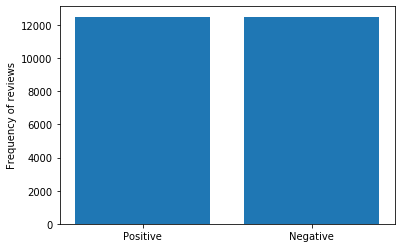

In [158]:
plt.bar(x=[1,2],height=[len(label_pos), len(label_neg)]);
plt.xticks([1,2],['Positive','Negative']);
plt.ylabel('Frequency of reviews')

In [31]:
def train(model, train_iter, valid_iter, epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss();
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss=[]; train_acc=[]; valid_loss=[]; valid_acc=[];
    for epoch in tqdm(range(epochs),position=0,leave=True):
        model.train();
        running_loss=0.;
        correct, total = 0,0
        steps = 0;
        for idx, batch in enumerate(train_iter):
            text, target = batch.text[0].to('cpu'), torch.autograd.Variable(batch.label).long().to('cpu');
            #conversion to long for label is required, but not sure why
            optimizer.zero_grad();
            output = model(text);
            loss = loss_fn(output, target);
            loss.backward();
            optimizer.step();
            
            steps+=1;
            
            running_loss+=loss.item()
            
            _,predicted = torch.max(output, 1);
            
            total += target.size(0);
            correct += (predicted==target).sum().item();
            
        train_loss.append(running_loss/len(train_iter));
        train_acc.append(correct/total)
        
        model.eval();
        running_loss=0.; correct,total=0,0;
#         with torch.no_grad():
#             for batch in valid_iter:
#                 text,target=batch.text[0], torch.autograd.Variable(batch.label).long();
                
#                 optimizer.zero_grad()
#                 output = model(text);
#                 loss = loss_fn(output,target);
#                 running_loss +=loss.item();
                
#                 total+=label.size(0);
#                 _,predicted = torch.max(output,1);
#                 correct +=(predicted==target).sum().item();
                
#         valid_loss.append(running_loss/len(valid_iter));
#         valid_acc.append(correct/total)
    return train_loss, valid_loss, train_acc, valid_acc
        

In [89]:
# Training function
def train_from_tutorial(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in tqdm(range(epochs),position=0,leave=True):
    #train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      # print(type(text), text.shape)
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)

      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

#     print(f'Epoch: {epoch + 1}, '
#           f'Training Loss: {running_loss/len(train_iter):.4f}, '
#           f'Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

#     print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
#            f'Validation Accuracy: {100*correct/total: .2f}%')

  return train_loss, train_acc, validation_loss, validation_acc



#### Vanilla RNN
Let's train a Vanilla RNN with 2 layers and 50 neurons in the hidden layer

In [32]:
class VanillaRNN(nn.Module):
    def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
        super(VanillaRNN,self).__init__();
        self.n_layers = layers
        self.hidden_size=hidden_size
        self.device = device;
        self.embeddings = nn.Embedding(vocab_size,embed_size);
        self.rnn = nn.RNN(embed_size,hidden_size,self.n_layers)
        self.fc = nn.Linear(self.n_layers*hidden_size,output_size);
    def forward(self,x):
        x=self.embeddings(x);
        x=x.permute(1,0,2);
        h0=torch.zeros(2,x.size()[1],self.hidden_size);
        output, hn=self.rnn(x,h0);
        hn=hn.permute(1,0,2);
        hn=hn.contiguous().reshape(hn.size()[0], hn.size()[1]*hn.size()[2])
        logits = self.fc(hn);
        return logits
vanillaRNN = VanillaRNN(2,2,50,vocab_size,100,'cpu');
train_loss, train_acc, valid_loss, valid_acc = train(vanillaRNN, 
                                                         train_iter, 
                                                         valid_iter, 
                                                         5, 2e-4)

100%|██████████| 5/5 [08:48<00:00, 101.63s/it]


In [52]:
train_tut_loss, train_tut_acc, valid_tut_loss, valid_tut_acc = train_from_tutorial(vanillaRNN,
                                                                                   'cpu',
                                                         train_iter, 
                                                         valid_iter, 
                                                         30, 2e-4)

100%|██████████| 30/30 [41:01<00:00, 81.06s/it]


I can't figure out why my training function gives higher loss and lower accuracy compared to the training function from the tutorial! The seeds are the same, and as far as I know, there seems to be no difference between the code between the two functions

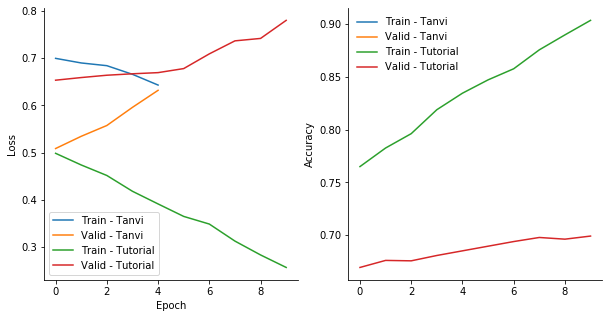

In [33]:
f,ax=plt.subplots(1,2,figsize=(10,5),sharex=True);
ax[0].plot(train_loss,label='Train - Tanvi'); ax[0].plot(valid_loss,label='Valid - Tanvi');
ax[0].plot(train_tut_loss,label='Train - Tutorial'); ax[0].plot(valid_tut_loss,label='Valid - Tutorial');
ax[0].set_ylabel('Loss'); ax[0].set_xlabel('Epoch'); ax[0].legend()

ax[1].plot(train_acc,label='Train - Tanvi'); ax[1].plot(valid_acc,label='Valid - Tanvi');
ax[1].plot(train_tut_acc,label='Train - Tutorial'); ax[1].plot(valid_tut_acc,label='Valid - Tutorial');
ax[1].set_ylabel('Accuracy')

ax[1].legend(frameon=False); sns.despine()

##### LSTM
Next, let's use an LSTM with 50 hidden layer neurons and see what the accuracy looks like.

In [62]:
class LSTM(nn.Module):
    def __init__(self,layers,output_size,hidden_size,vocab_size,embed_size):
        super(LSTM,self).__init__();
        self.n_layers=layers;
        self.output_size=output_size;
        self.hidden_size=hidden_size;
        
        self.word_embeddings = nn.Embedding(vocab_size,embed_size);
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=self.n_layers)
        self.fc = nn.Linear(self.n_layers*self.hidden_size, self.output_size);
        
    def forward(self,input_sentences):
        inp = self.word_embeddings(input_sentences).permute(1,0,2);
        hidden = (torch.randn(self.n_layers, inp.shape[1], self.hidden_size),
        torch.randn(self.n_layers, inp.shape[1], self.hidden_size))
        
        inp = self.dropout(inp);
        output, hidden = self.lstm(inp, hidden);
        
        h_n = hidden[0].permute(1, 0, 2)
        h_n = h_n.contiguous().view(h_n.shape[0], -1)

        logits = self.fc(h_n)
        
        return logits
    
sampleLSTM = LSTM(2, 2, 50, vocab_size, 100)
sampleLSTM
        
        
        

LSTM(
  (word_embeddings): Embedding(113858, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(100, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [63]:
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train_from_tutorial(sampleLSTM,
                                                                                                 'cpu',
                                                                                   train_iter,
                                                                                   valid_iter,
                                                                                   30,
                                                                                   0.0003)


100%|██████████| 30/30 [59:43<00:00, 128.16s/it]


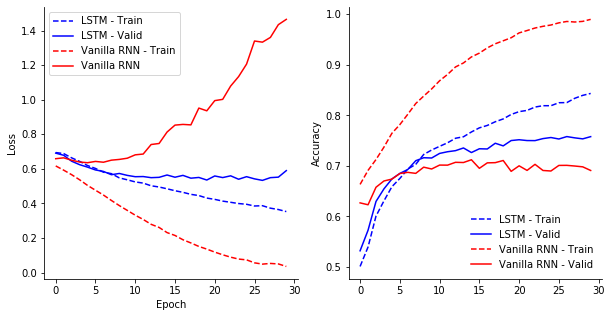

In [64]:

f,ax=plt.subplots(1,2,figsize=(10,5),sharex=True);
ax[0].plot(lstm_train_loss,label='LSTM - Train',color='b',ls='--'); 
ax[0].plot(lstm_validation_loss,label='LSTM - Valid',color='b',ls='-');
ax[0].plot(train_tut_loss,label='Vanilla RNN - Train',color='r',ls='--'); 
ax[0].plot(valid_tut_loss,label='Vanilla RNN',color='r',ls='-');
ax[0].set_ylabel('Loss'); ax[0].set_xlabel('Epoch'); ax[0].legend()

ax[1].plot(lstm_train_acc,label='LSTM - Train',color='b',ls='--'); 
ax[1].plot(lstm_validation_acc,label='LSTM - Valid',color='b',ls='-');
ax[1].plot(train_tut_acc,label='Vanilla RNN - Train',color='r',ls='--'); 
ax[1].plot(valid_tut_acc,label='Vanilla RNN - Valid',color='r',ls='-');
ax[1].set_ylabel('Accuracy')

ax[1].legend(frameon=False); sns.despine()

##### Bi-LSTM 
Let's use a bi-LSTM for the problem and compare the 3 approaches

In [90]:
class biLSTM(nn.Module):
    def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size):
        super(biLSTM, self).__init__();
        self.n_layers = layers;
        self.output_size = output_size;
        self.hidden_size = hidden_size;
        
        self.word_embeddings = nn.Embedding(vocab_size, embed_size);
        self.dropout = nn.Dropout(p=0.5);
        self.lstm = nn.LSTM(embed_size, self.hidden_size, num_layers = self.n_layers,
                           bidirectional=True);
        self.fc = nn.Linear(self.n_layers*2*self.hidden_size, self.output_size);
        
    def forward(self, input_sentences):
        inp = self.word_embeddings(input_sentences).permute(1,0,2);
        inp = self.dropout(inp);
        
        hidden = (torch.randn(self.n_layers*2, inp.shape[1], self.hidden_size),
        torch.randn(self.n_layers*2, inp.shape[1], self.hidden_size))
        
        output, hidden = self.lstm(inp, hidden);
        
        ## I still don't understand why we need to permute, nor why do we do the second line
        h_n = hidden[0].permute(1, 0, 2)
        h_n = h_n.contiguous().view(h_n.shape[0], -1)
        
        logits = self.fc(h_n)
        return logits
    
sample_bilstm = biLSTM(2, 2, 50, vocab_size, 100)
sample_bilstm

bilstm_train_loss, bilstm_train_acc, bilstm_validation_loss, bilstm_validation_acc = train_from_tutorial(sample_bilstm,
                                                                                                         'cpu',
                                                                    train_iter,
                                                                    valid_iter,
                                                                    30,0.0003)



100%|██████████| 30/30 [1:10:03<00:00, 150.40s/it]


In [160]:
smh_loss, smh_acc, _, \
_ = train_from_tutorial(sample_bilstm,'cpu',train_iter,valid_iter,1,0.0003)

100%|██████████| 1/1 [02:16<00:00, 136.18s/it]


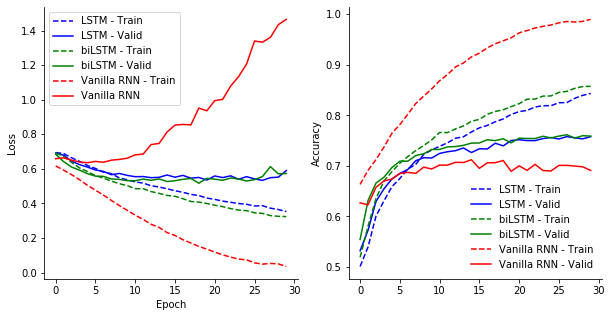

In [91]:
f,ax=plt.subplots(1,2,figsize=(10,5),sharex=True);
ax[0].plot(lstm_train_loss,label='LSTM - Train',color='b',ls='--'); 
ax[0].plot(lstm_validation_loss,label='LSTM - Valid',color='b',ls='-');
ax[0].plot(bilstm_train_loss,label='biLSTM - Train',color='g',ls='--'); 
ax[0].plot(bilstm_validation_loss,label='biLSTM - Valid',color='g',ls='-');
ax[0].plot(train_tut_loss,label='Vanilla RNN - Train',color='r',ls='--'); 
ax[0].plot(valid_tut_loss,label='Vanilla RNN',color='r',ls='-');
ax[0].set_ylabel('Loss'); ax[0].set_xlabel('Epoch'); ax[0].legend()

ax[1].plot(lstm_train_acc,label='LSTM - Train',color='b',ls='--'); 
ax[1].plot(lstm_validation_acc,label='LSTM - Valid',color='b',ls='-');
ax[1].plot(bilstm_train_acc,label='biLSTM - Train',color='g',ls='--'); 
ax[1].plot(bilstm_validation_acc,label='biLSTM - Valid',color='g',ls='-');
ax[1].plot(train_tut_acc,label='Vanilla RNN - Train',color='r',ls='--'); 
ax[1].plot(valid_tut_acc,label='Vanilla RNN - Valid',color='r',ls='-');
ax[1].set_ylabel('Accuracy')

ax[1].legend(frameon=False); sns.despine()

### Supplementary:
##### Seq2Seq model with RNN Encoder & Decoder architectures
Up untill now, we have used LSTM and RNN for classification of our dataset. But for applications where we need to generate text based on a text sequence, e.g., for translation purposes or chatbot services, we would want a sequence-to-sequence model. In such a model, we use an RNN or a sequence of RNNs  as the encoder and another RNN or sequence of RNNs as decoder.

Here, we will use a seq2seq model to translate English into Pig-latin, using a GRU as an encoder and xx as a decoder

In [175]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self,vocab_size, embed_size, num_hiddens, 
                 num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs);
        self.embedding = nn.Embedding(vocab_size, embed_size);
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        # we don't need the fully-connected layer since we are not classifying
    def forward(self, X, *args):
        X = self.embedding(X).permute(1,0,2);
        output, state = self.rnn(X);
        return output, state
X = torch.zeros((4, 7), dtype=torch.long)
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2);
print(encoder)

class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self,vocab_size, embed_size, num_hiddens, 
                 num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs);
        self.embedding = nn.Embedding(vocab_size, embed_size);
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.fc = nn.Linear(num_hiddens, vocab_size); #we need to output the size of vocab
    def forward(self, X, state):
        X = self.embedding(X).permute(1,0,2);
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.fc(output).permute(1, 0, 2)
        return output, state
    def init_state(self, encoded_outputs, *args):
        return encoded_outputs[1]
    
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, len(state), state[0].shape

Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(8, 16, num_layers=2)
)


(torch.Size([4, 7, 10]), 2, torch.Size([4, 16]))

**Loss function of the seq2seq model**

The decoder predicts a sequence with special padding tokens to predict sequences of the same length. But these should be excluded from the loss calculation. Here we define a sequences to get rid of the tokens added during padding. We'll use this masking code to get rid of the cross-entropy loss for the padded positions

In [203]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                      device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

class MaskedSoftMaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label);
        weights = sequence_mask(weights, valid_len);
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftMaxCELoss, self).forward(pred.permute(0,2,1),label)
        weighted_loss = (unweighted_loss*weights).mean(dim=1)
        
        return weighted_loss
        

# X = torch.tensor([[1, 2, 3], [4, 5, 6]])
# print(sequence_mask(X, torch.tensor([1, 2])))
# X = torch.ones(2, 3, 4)
# print(sequence_mask(X, torch.tensor([1, 2]), value=-1))

In [206]:
#Train a seq2seq model
def train_sux2suk(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])


    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftMaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                          xlim=[10, num_epochs])
    for epoch in tqdm(range(num_epochs),position=0,leave=True):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                              device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
#             pdb.set_trace();
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
            if (epoch + 1) % 10 == 0:
                animator.add(epoch + 1, (metric[0] / metric[1],))
#         print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
#             f'tokens/sec on {str(device)}')

100%|██████████| 300/300 [04:30<00:00,  1.69s/it]


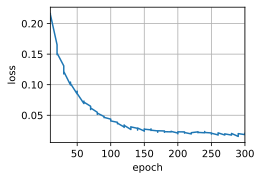

In [207]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_sux2suq(net, train_iter, lr, num_epochs, tgt_vocab, 'cpu')